## Imports

In [15]:
# Preproces Imports
import os
import numpy as np
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt

# Model Imports
from keras.preprocessing.image import img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
import tensorflow as tf
from tensorflow.keras.models import model_from_json
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from skimage.transform import resize

## Initialisation

In [16]:
############## PREPROCESSING DEFINITIONS ##############

# Path to the original data folder
PATH_TO_DATA_FOLDER = "D:\Files\Projects College\Capstone\data_unclean\Test"

# Path to the initially empty folder to store the resized images
PATH_TO_RESIZED_FOLDER = "D:\Files\Projects College\Capstone\data_unclean\Test_resized"

# Path to the initially empty folder to store the final greyscale images
PATH_TO_GREYSCALE_FOLDER = "D:\Files\Projects College\Capstone\data_unclean\Test_BW"

STANDARD_WIDTH = 256    # 420, 352
STANDARD_HEIGHT = 256    # 285, 240

SHOW_PROGRESS_COUNT = 10    # Shows progress after this many number of images are processed



############## MODEL DEFINITIONS ##############

PATH_TO_MODEL_1_JSON = "D:\Files\Projects College\Capstone\WebApp\models\model_1\model.json"
PATH_TO_MODEL_1_WEIGHTS = "D:\Files\Projects College\Capstone\WebApp\models\model_1\model.h5"

PATH_TO_MODEL_2_JSON = "D:\Files\Projects College\Capstone\WebApp\models\model_2\model2.json"
PATH_TO_MODEL_2_WEIGHTS = "D:\Files\Projects College\Capstone\WebApp\models\model_2\model2.h5"

## Distribution of widths and heights in a folder

In [3]:
def plot_distribution(x, title_text):
    values, bins, patches = plt.hist(x, bins = 5)
    values = [int(x) for x in values]
    bins = [int(x) for x in bins]
    max_frequency = max(values)
    max_frequency_indices = [i for i, e in enumerate(values) if e == max_frequency]
    max_bin_ends = [(bins[x], bins[x + 1]) for x in max_frequency_indices]
    max_bin_ends = [str(x) for x in max_bin_ends]
    plt.title("Distribution of " + title_text + ", Max bin: " + ", ".join(max_bin_ends))
    plt.show()

In [4]:
def plot_all_distributions(PATH_TO_DATA_FOLDER):
    all_widths = []
    all_heights = []

    for file_name in os.listdir(PATH_TO_DATA_FOLDER):
        image = Image.open(PATH_TO_DATA_FOLDER + "\\" + file_name)
        width, height = image.size
        if(height < 500 and width < 500):
#         if(True):
            all_widths.append(width)
            all_heights.append(height)

    plot_distribution(all_widths, "Widths")
    plot_distribution(all_heights, "Heights")

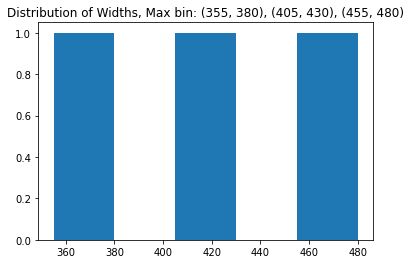

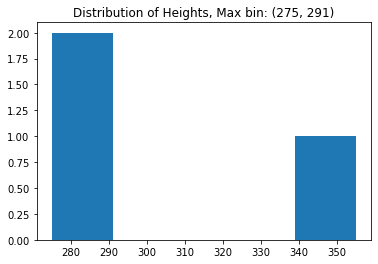

In [5]:
plot_all_distributions(PATH_TO_DATA_FOLDER)

## Resizing Image

In [6]:
def resize_all_images(PATH_TO_DATA_FOLDER, PATH_TO_RESIZED_FOLDER, STANDARD_WIDTH, STANDARD_HEIGHT):
    count = 0
    for file_name in os.listdir(PATH_TO_DATA_FOLDER):
        if(count % SHOW_PROGRESS_COUNT == 0):
            print("Finished " + str(count))
        count += 1
        image = Image.open(PATH_TO_DATA_FOLDER + "\\" + file_name).resize((STANDARD_WIDTH, STANDARD_HEIGHT))
        image.save(PATH_TO_RESIZED_FOLDER + "\\" + file_name)
    print("Finished all")

In [7]:
resize_all_images(PATH_TO_DATA_FOLDER, PATH_TO_RESIZED_FOLDER, STANDARD_WIDTH, STANDARD_HEIGHT)

Finished 0
Finished 10
Finished all


## Convert Color to Greyscale

In [8]:
def color_to_grayscale(PATH_TO_RESIZED_FOLDER, PATH_TO_GREYSCALE_FOLDER):
    count = 0
    for file_name in os.listdir(PATH_TO_RESIZED_FOLDER):
        if(count % SHOW_PROGRESS_COUNT == 0):
            print("Finished " + str(count))
        count += 1
        image = Image.open(PATH_TO_RESIZED_FOLDER + "\\" + file_name).convert('L')
        image.save(PATH_TO_GREYSCALE_FOLDER + "\\" + file_name)
    print("Finished all")

In [9]:
color_to_grayscale(PATH_TO_RESIZED_FOLDER, PATH_TO_GREYSCALE_FOLDER)

Finished 0
Finished 10
Finished all


## Model 1 Output

In [3]:
json_file = open(PATH_TO_MODEL_1_JSON, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(PATH_TO_MODEL_1_WEIGHTS)

Output of the Model


D:\Programs\lib\site-packages\skimage\color\colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 38 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


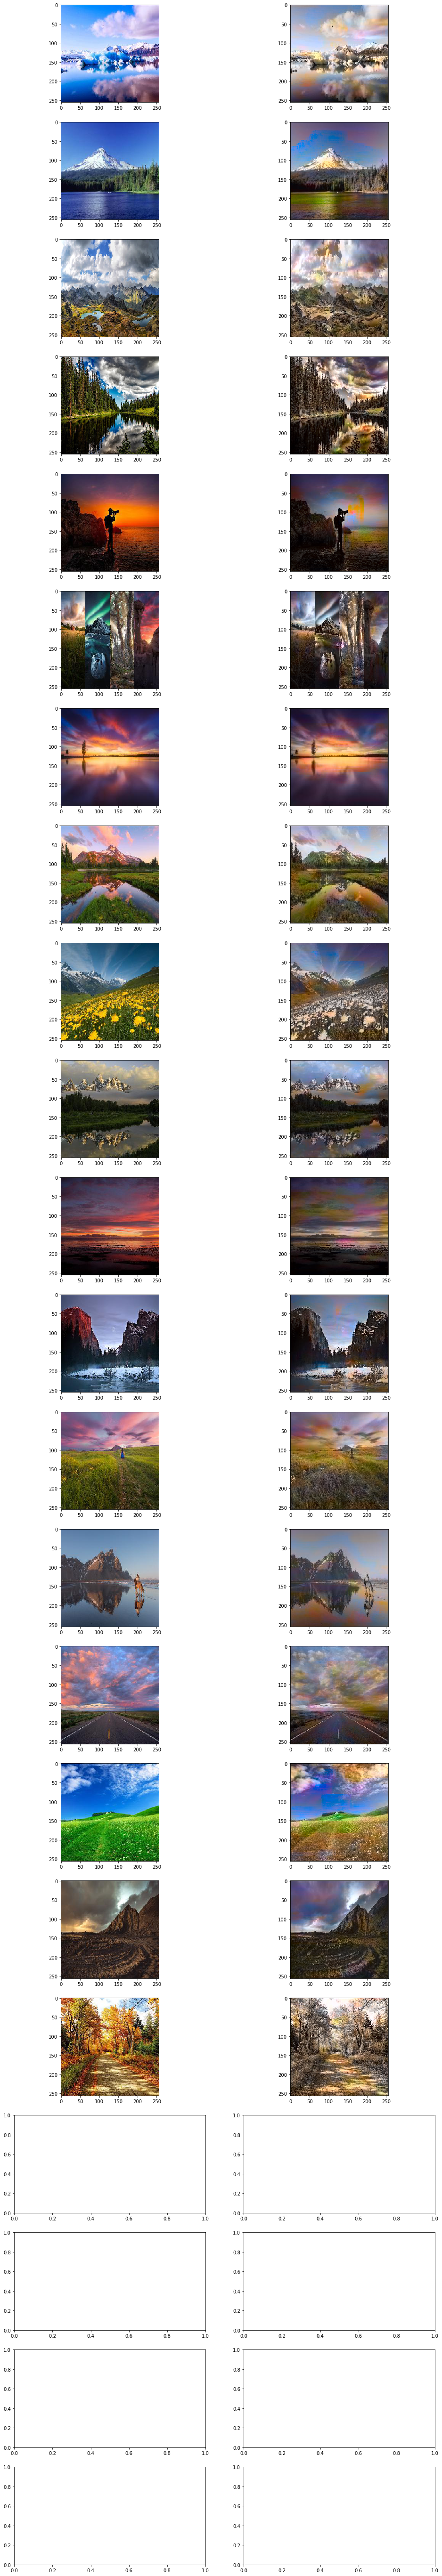

In [10]:
fig, ax = plt.subplots(22, 2, figsize=(16, 100))
row = 0
colorize = []

for filename in os.listdir(PATH_TO_RESIZED_FOLDER):
    colorize.append(img_to_array(load_img(PATH_TO_RESIZED_FOLDER + "\\" + filename)))
    ax[row, 0].imshow(load_img(PATH_TO_RESIZED_FOLDER + "\\" + filename), interpolation = 'nearest')
    row += 1

colorize = np.array(colorize, dtype = float)
colorize = rgb2lab(1.0 / 255 * colorize)[:, :, :, 0]
colorize = colorize.reshape(colorize.shape + (1, ))

# Test model
output = loaded_model.predict(colorize)
output = output * 128

# Output colorizations
row = 0
for i in range(len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:, :, 0] = colorize[i][:, :, 0]
    cur[:, :, 1:] = output[i]
    resImage = lab2rgb(cur)
    ax[row, 1].imshow(resImage, interpolation = 'nearest')
    row += 1

## Model 2 Output

In [5]:
json_file = open(PATH_TO_MODEL_2_JSON, 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights(PATH_TO_MODEL_2_WEIGHTS)

In [23]:
inception = InceptionResNetV2(weights = 'imagenet', include_top = True)

def create_inception_embedding(grayscaled_rgb):
    grayscaled_rgb_resized = []
    for i in grayscaled_rgb:
        i = resize(i, (299, 299, 3), mode = 'constant')
        grayscaled_rgb_resized.append(i)
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    embed = inception.predict(grayscaled_rgb_resized)
    return embed

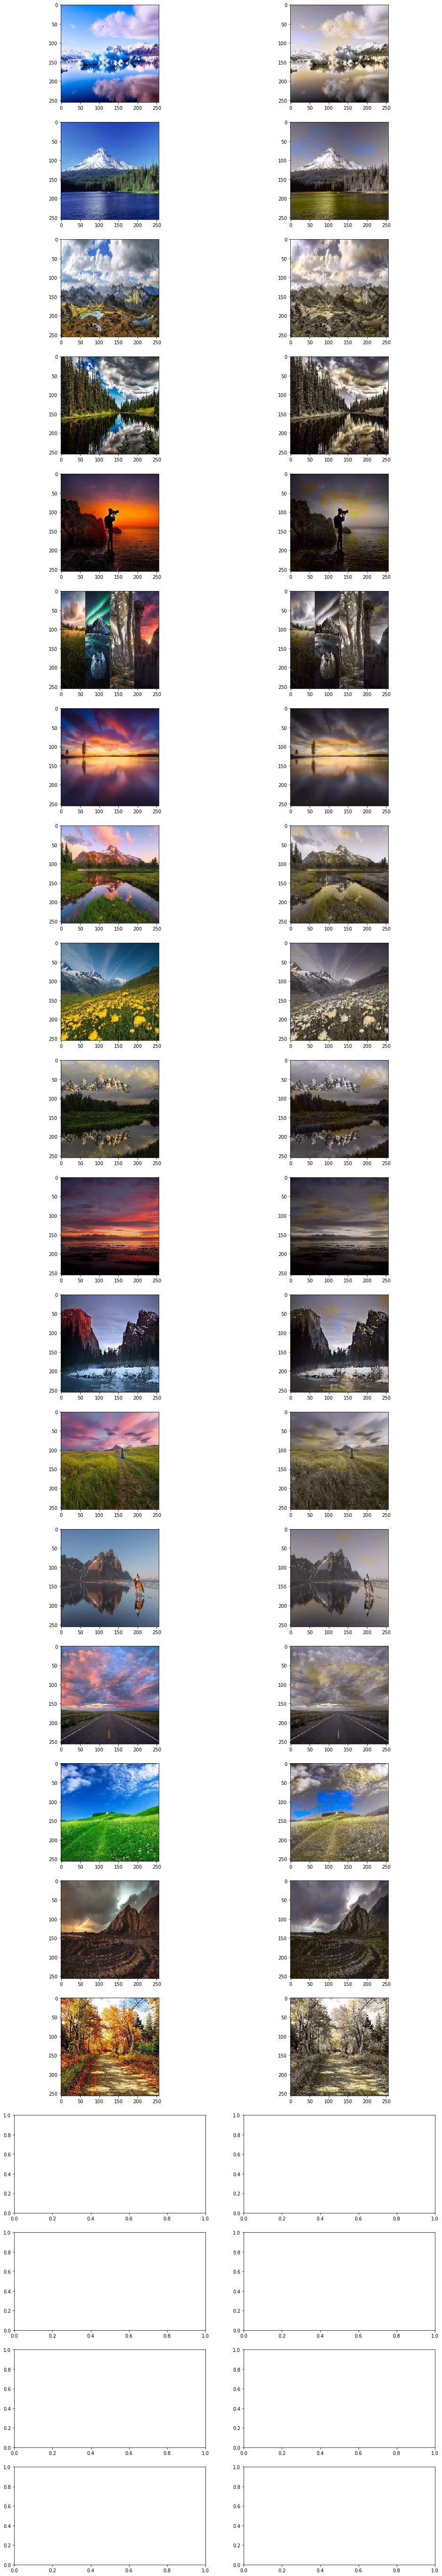

In [24]:
fig, ax = plt.subplots(22, 2, figsize=(16, 100))
row = 0
color_me = []


for filename in os.listdir(PATH_TO_RESIZED_FOLDER):
    color_me.append(img_to_array(load_img(PATH_TO_RESIZED_FOLDER + "\\" + filename)))
    ax[row, 0].imshow(load_img(PATH_TO_RESIZED_FOLDER + "\\" + filename), interpolation = 'nearest')
    row += 1

color_me = np.array(color_me, dtype = float)
gray_me = gray2rgb(rgb2gray(1.0 / 255 * color_me))
color_me_embed = create_inception_embedding(gray_me)
color_me = rgb2lab(1.0 / 255 * color_me)[:, :, :, 0]
color_me = color_me.reshape(color_me.shape + (1, ))


# Test model
output = model.predict([color_me, color_me_embed])
output = output * 128

# Output colorizations
row = 0
for i in range(len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:, :, 0] = color_me[i][:, :, 0]
    cur[:, :, 1:] = output[i]
    resImage = lab2rgb(cur)
    ax[row, 1].imshow(resImage, interpolation = 'nearest')
    row += 1